# 1. Install Necessary Libraries

In [1]:
%%capture --no-stderr
%pip install -U langgraph langchain langchain_openai

# 2. Import necessary dependencies and set environment variables

In [2]:
import os
import getpass

from langchain_openai import ChatOpenAI

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")

llm = ChatOpenAI(model="gpt-4o-mini")

OPENAI_API_KEY: ··········


# Agentic System

An Agentic System, in the context of AI, refers to a system where one or more Agents are involved. These agents are not just passive entities that respond to commands but exhibit characteristics like:

Autonomy: They can act independently and make decisions.

Proactiveness: They can initiate actions and pursue goals.

Adaptability: They can learn and adapt to changes in their environment.

Goal-Oriented Behavior: They strive to achieve specific objectives or fulfill a particular purpose.

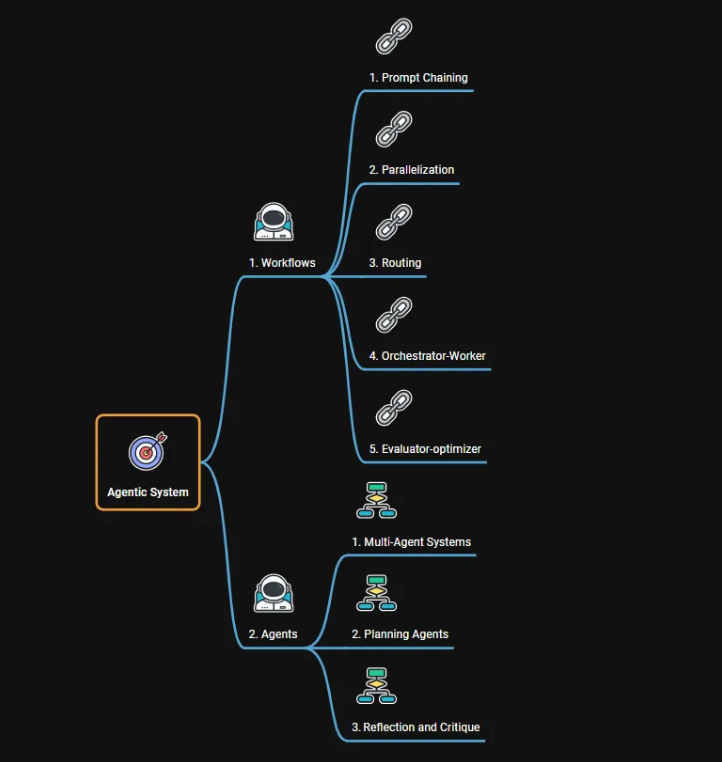

Detailed Blog : https://aiproductplaybook.substack.com/p/101-what-the-heck-are-agentic-system

# 3. Workflow - Evaluator optimizer

In the evaluator-optimizer workflow, one LLM call generates a response while another provides evaluation and feedback in a loop.

When to use this workflow: This workflow is particularly effective when we have clear evaluation criteria, and when iterative refinement provides measurable value. The two signs of good fit are, first, that LLM responses can be demonstrably improved when a human articulates their feedback; and second, that the LLM can provide such feedback. This is analogous to the iterative writing process a human writer might go through when producing a polished document.

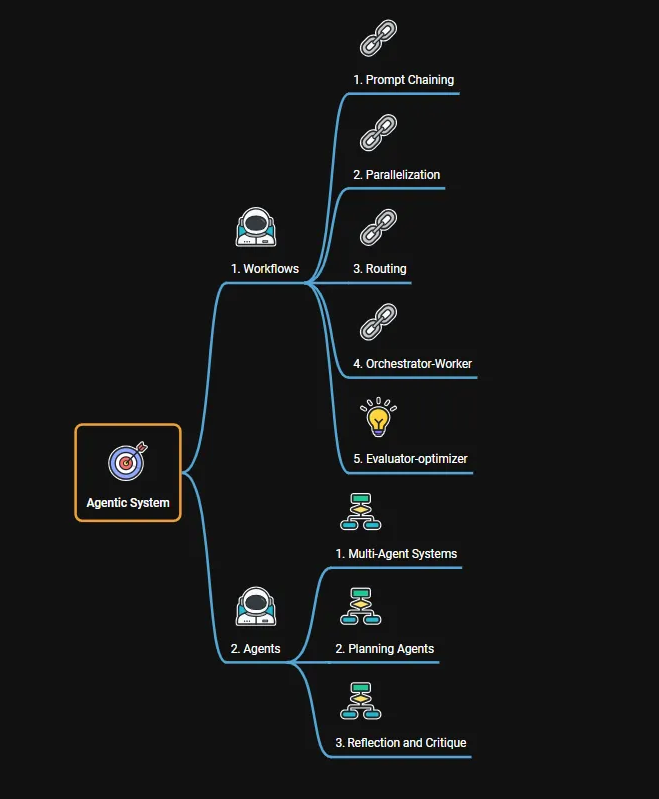

Detailed Blog : https://aiproductplaybook.substack.com/p/106-what-the-heck-are-evaluator-optimizer

### a. Import LangGraph and other dependencies

In [98]:
from typing_extensions import TypedDict , Literal
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from langchain_core.messages import HumanMessage, SystemMessage
from pydantic import BaseModel, Field
from typing import Annotated, List
import operator

### b. Defining the State Classes

The code defines a State class using TypedDict to represent the structure of data within a specific workflow,  related to joke generation & evaluation. This State object will be used to store and track various aspects of the joke, such as the joke itself, its topic, feedback received, and a label indicating whether the joke is considered funny.


In [99]:
# Graph state
class State(TypedDict):
    joke: str
    topic: str
    feedback: str
    funny_or_not: str

### c. Defining a Schema for Feedback & Augmenting the LLM with the Schema

In [100]:
# Schema for structured output to use in evaluation
class Feedback(BaseModel):
    grade: Literal["funny", "not funny"] = Field(
        description="Decide if the joke is funny or not.",
    )
    feedback: str = Field(
        description="If the joke is not funny, provide feedback on how to improve it.",
    )


# Augment the LLM with schema for structured output
evaluator = llm.with_structured_output(Feedback)

### d. Defining Node Functions:

1. llm_call_generator(state: State) Function

This function handles the generation of jokes.
It takes the current state as input, which includes the topic of the joke.
If the state contains a feedback field (meaning previous attempts to generate a joke have received feedback), the function uses the LLM to generate a new joke while considering the provided feedback.
If no feedback is available, the function simply generates a joke based on the topic.
The function returns a dictionary with the generated joke.

2. llm_call_evaluator(state: State) Function

This function handles the evaluation of the generated joke.
It takes the current state as input, which includes the joke.
It uses the augmented LLM (evaluator) to evaluate the joke.
The evaluator is expected to generate a Feedback object (as defined in the previous snippet), containing a grade ("funny" or "not funny") and feedback (if the joke is not funny).
The function returns a dictionary with the funny_or_not grade and the feedback.

3. route_joke(state: State) Function

This function acts as a decision-making point in the workflow.
It takes the current state as input, specifically looking at the funny_or_not field.
Based on the funny_or_not value:
If funny_or_not is "funny", it returns "Accepted", indicating that the joke is considered successful and the process can potentially end.
If funny_or_not is "not funny", it returns "Rejected + Feedback", indicating that the joke should be re-generated, taking into account the provided feedback.

In [101]:
# Nodes
def llm_call_generator(state: State):
    """LLM generates a joke"""

    if state.get("feedback"):
        msg = llm.invoke(
            f"Write a joke about {state['topic']} but take into account the feedback: {state['feedback']}"
        )
    else:
        msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def llm_call_evaluator(state: State):
    """LLM evaluates the joke"""

    grade = evaluator.invoke(f"Grade the joke {state['joke']}")
    return {"funny_or_not": grade.grade, "feedback": grade.feedback}


# Conditional edge function to route back to joke generator or end based upon feedback from the evaluator
def route_joke(state: State):
    """Route back to joke generator or end based upon feedback from the evaluator"""

    if state["funny_or_not"] == "funny":
        return "Accepted"
    elif state["funny_or_not"] == "not funny":
        return "Rejected + Feedback"

### e. Build workflow

This code block defines a state graph that represents a workflow for iteratively generating and refining jokes. It includes nodes for joke generation and evaluation, and defines a loop that continues generating and evaluating jokes until an "Accepted" joke is produced. This iterative process allows the system to learn and improve the quality of the generated jokes over time.

In [102]:
# Build workflow
optimizer_builder = StateGraph(State)

# Add the nodes
optimizer_builder.add_node("llm_call_generator", llm_call_generator)
optimizer_builder.add_node("llm_call_evaluator", llm_call_evaluator)

# Add edges to connect nodes
optimizer_builder.add_edge(START, "llm_call_generator")
optimizer_builder.add_edge("llm_call_generator", "llm_call_evaluator")
optimizer_builder.add_conditional_edges(
    "llm_call_evaluator",
    route_joke,
    {  # Name returned by route_joke : Name of next node to visit
        "Accepted": END,
        "Rejected + Feedback": "llm_call_generator",
    },
)

# Compile the workflow
optimizer_workflow = optimizer_builder.compile()

### f. Visualize the workflow graph

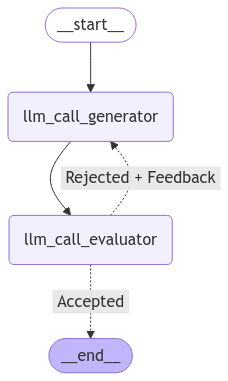

In [103]:
# Show the workflow
display(Image(optimizer_workflow.get_graph().draw_mermaid_png()))

### g. Invoke the Workflow - Evaluator optimizer

In [104]:
# Invoke
state = optimizer_workflow.invoke({"topic": "Dorks"})
print(state["joke"])

Why did the dork bring a ladder to the bar?

Because they heard the drinks were on the house!


In [105]:
# Invoke
state = optimizer_workflow.invoke({"topic": "Roger federer"})
print(state["joke"])

Why did Roger Federer bring a ladder to the tennis match?

Because he heard the competition was on a whole new level!


In [106]:
# Invoke
state = optimizer_workflow.invoke({"topic": "Elon Musk"})
print(state["joke"])

Why did Elon Musk bring a ladder to his rocket launch?

Because he wanted to reach new heights!
